In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir('/data/rsg/nlp/sdobers/amine/diffdock-protein/src')

from args import parse_args
from data import load_data, get_data
from data.data import BindingDataset
from model import load_model, to_cuda
from utils import printt, print_res, log, get_unixtime, compute_rmsd
from train import train, evaluate, evaluate_pose
from helpers import WandbLogger, TensorboardLogger
from sample import sample

In [4]:
from notebooks.utils_notebooks import Dict2Class

In [5]:
CUDA_VISIBLE_DEVICE = 1
torch.cuda.set_device(CUDA_VISIBLE_DEVICE)
print(torch.cuda.is_available())

True


In [6]:
#PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_medium_model/'
#PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_large_model/'
#PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_medium_model_no_bn_no_dropout/'
PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_medium_model_whole_db5/'

In [7]:
# load args
with open(os.path.join(PATH, 'args.yaml')) as f:
    args = yaml.safe_load(f)
args = Dict2Class(args)

args.num_gpu = 1
args.gpu = CUDA_VISIBLE_DEVICE
#args.data_file = args.data_file.replace('data_file', 'data_file_only_val')
args.checkpoint_path = PATH
args.use_orientation_features = False
if 'large' in PATH:
    args.batch_size = 4

In [8]:
# load raw data
data = load_data(args)
data_params = data.data_params

data loading: 100%|█| 253/253 [00:00<00:00, 755811


05:54:55 Loaded processed data from cache
05:55:02 Loaded cached ESM embeddings
05:55:02 finished tokenizing residues with ESM
05:55:02 finished tokenizing all inputs
05:55:02 253 entries loaded


In [9]:
loaders_for_reverse_diffusion = get_data(data, 0, args, for_reverse_diffusion=True)


In [10]:
train_loader = loaders_for_reverse_diffusion["train"]
val_loader = loaders_for_reverse_diffusion["val"]
print(f'len train: {len(train_loader)}, len val: {len(val_loader)}')

len train: 203, len val: 25


In [11]:
# get model and load checkpoint, if relevant
model = load_model(args, data_params, 0)
model = to_cuda(model, args)

numel = sum([p.numel() for p in model.parameters()])
printt('Model with', numel, 'parameters')

/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


05:58:49 loaded model with kwargs: 
05:58:49 loaded checkpoint from /data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_medium_model_whole_db5/fold_0/model_best_468_36_0.749_0.749.pth
05:59:17 Model with 261970 parameters


In [16]:
# run reverse diffusion process
samples_val = sample(val_loader, model, args)
# samples_val now contains all the graphs, with graph["ligand"] contains the positions predicted by the model

06:00:43 Completed 0 out of 40 steps
06:00:47 Completed 1 out of 40 steps
06:00:50 Completed 2 out of 40 steps
06:00:52 Completed 3 out of 40 steps
06:00:54 Completed 4 out of 40 steps
06:00:56 Completed 5 out of 40 steps
06:00:58 Completed 6 out of 40 steps
06:01:00 Completed 7 out of 40 steps
06:01:02 Completed 8 out of 40 steps
06:01:03 Completed 9 out of 40 steps
06:01:05 Completed 10 out of 40 steps
06:01:06 Completed 11 out of 40 steps
06:01:08 Completed 12 out of 40 steps
06:01:09 Completed 13 out of 40 steps
06:01:10 Completed 14 out of 40 steps
06:01:12 Completed 15 out of 40 steps
06:01:13 Completed 16 out of 40 steps
06:01:14 Completed 17 out of 40 steps
06:01:15 Completed 18 out of 40 steps
06:01:16 Completed 19 out of 40 steps
06:01:17 Completed 20 out of 40 steps
06:01:18 Completed 21 out of 40 steps
06:01:19 Completed 22 out of 40 steps
06:01:21 Completed 23 out of 40 steps
06:01:22 Completed 24 out of 40 steps
06:01:23 Completed 25 out of 40 steps
06:01:24 Completed 26 

In [18]:
val_score = evaluate_pose(val_loader, samples_val)

In [19]:
rmsds_val = np.array(val_score["rmsd"])
reverse_diffusion_metrics_val = {'rmsds_lt2': (100 * (rmsds_val < 2).sum() / len(rmsds_val)),
                             'rmsds_lt5': (100 * (rmsds_val < 5).sum() / len(rmsds_val)),
                             'rmsds_mean': rmsds_val.mean(),
                             'rmsds_median': np.median(rmsds_val)}
print(reverse_diffusion_metrics_val)

{'rmsds_lt2': 0.0, 'rmsds_lt5': 0.0, 'rmsds_mean': 59.82955, 'rmsds_median': 52.96353}


## now train

In [20]:
samples_train = sample(train_loader, model, args)


06:03:12 Completed 0 out of 40 steps
06:03:36 Completed 1 out of 40 steps
06:03:58 Completed 2 out of 40 steps
06:04:20 Completed 3 out of 40 steps
06:04:40 Completed 4 out of 40 steps
06:05:00 Completed 5 out of 40 steps
06:05:17 Completed 6 out of 40 steps
06:05:34 Completed 7 out of 40 steps
06:05:49 Completed 8 out of 40 steps
06:06:03 Completed 9 out of 40 steps
06:06:16 Completed 10 out of 40 steps
06:06:28 Completed 11 out of 40 steps
06:06:40 Completed 12 out of 40 steps
06:06:51 Completed 13 out of 40 steps
06:07:02 Completed 14 out of 40 steps
06:07:13 Completed 15 out of 40 steps
06:07:23 Completed 16 out of 40 steps
06:07:33 Completed 17 out of 40 steps
06:07:43 Completed 18 out of 40 steps
06:07:52 Completed 19 out of 40 steps
06:08:02 Completed 20 out of 40 steps
06:08:11 Completed 21 out of 40 steps
06:08:20 Completed 22 out of 40 steps
06:08:30 Completed 23 out of 40 steps
06:08:39 Completed 24 out of 40 steps
06:08:48 Completed 25 out of 40 steps
06:08:57 Completed 26 

In [24]:
train_score = evaluate_pose(train_loader, samples_train)

In [25]:
rmsds_train = np.array(train_score["rmsd"])
reverse_diffusion_metrics_train = {'rmsds_lt2': (100 * (rmsds_train < 2).sum() / len(rmsds_train)),
                             'rmsds_lt5': (100 * (rmsds_train < 5).sum() / len(rmsds_train)),
                             'rmsds_mean': rmsds_train.mean(),
                             'rmsds_median': np.median(rmsds_train)}
print(reverse_diffusion_metrics_train)

{'rmsds_lt2': 0.0, 'rmsds_lt5': 0.0, 'rmsds_mean': 65.00141, 'rmsds_median': 59.79863}


In [19]:
rmsds.min()

0.6305682

tensor(1.0215)


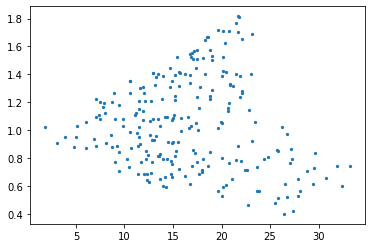

In [207]:
true_graph, pred_graph = val_dataset_without_noise[rmsds.argmin()], samples_val[rmsds.argmin()]
true_xyz = true_graph["ligand"].pos
pred_xyz = pred_graph["ligand"].pos

print(compute_rmsd(true_xyz, pred_xyz))

#dist_from_com = torch.norm(true_xyz-true_xyz.mean(0), p=2, dim=1)
dist_from_com = torch.norm(pred_xyz-pred_xyz.mean(0), p=2, dim=1)


square_deviation_per_residue = ((true_xyz-pred_xyz)**2).sum(-1)
plt.scatter(dist_from_com, square_deviation_per_residue, s=5)
plt.show()


In [18]:
num_residues = []
average_dist_from_com = []
max_dist_from_com = []
for true_graph, pred_graph in tqdm(zip(val_dataset_without_noise, samples_val)):
    
    true_xyz = true_graph["ligand"].pos
    pred_xyz = pred_graph["ligand"].pos
    
    num_residues.append(true_xyz.shape[0])
    
    dist_from_com = torch.norm(true_xyz-true_xyz.mean(0), p=2, dim=1)
    average_dist_from_com.append(dist_from_com.mean())
    max_dist_from_com.append(dist_from_com.max())
    
    dist_from_com_pred = torch.norm(pred_xyz-pred_xyz.mean(0), p=2, dim=1)
    #print(f'MEAN. true: {dist_from_com.mean()}. pred: {dist_from_com_pred.mean()}')
    #print(f'MAX. true: {dist_from_com.max()}. pred: {dist_from_com_pred.max()}')
    
    #square_deviation_per_residue = ((true_xyz-pred_xyz)**2).sum(-1)
    #plt.scatter(dist_from_com, square_deviation_per_residue, s=5)
    #plt.show()
    #print(true_xyz.shape)
    #print(pred_xyz.shape)
    #break
num_residues = np.array(num_residues)
average_dist_from_com = np.array(average_dist_from_com)
max_dist_from_com = np.array(max_dist_from_com)
print(num_residues.shape)
print(average_dist_from_com.shape)
print(max_dist_from_com.shape)

985it [00:00, 1598.41it/s]

(985,)
(985,)
(985,)


In [91]:
a = torch.Tensor([[1,1],[0,0], [-4,-4]])
b = a-torch.mean(a, dim=0)
print(b)
c = torch.norm(b, p=2, dim=1)
c.max()

tensor([[ 2.,  2.],
        [ 1.,  1.],
        [-3., -3.]])


tensor(4.2426)

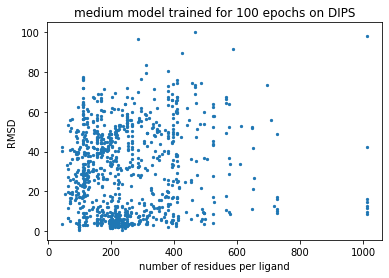

In [19]:
plt.scatter(num_residues, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("number of residues per ligand")
plt.ylabel("RMSD")
plt.show()

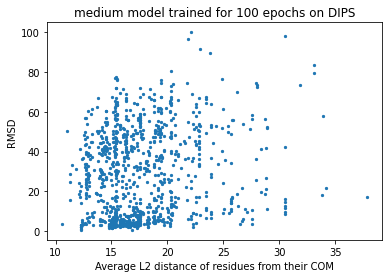

In [21]:
plt.scatter(average_dist_from_com, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("Average L2 distance of residues from their COM")
plt.ylabel("RMSD")
plt.show()

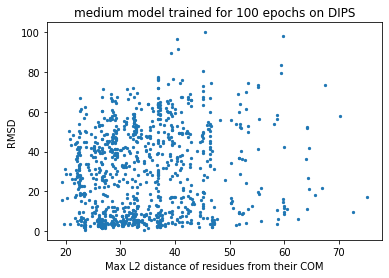

In [22]:
plt.scatter(max_dist_from_com, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("Max L2 distance of residues from their COM")
plt.ylabel("RMSD")
plt.show()

In [42]:
from torch_geometric.loader import DataLoader

[autoreload of sample failed: Traceback (most recent call last):
  File "/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'sample'
]


In [44]:
test_loader = DataLoader(val_loader, batch_size=args.batch_size)

In [54]:
for complex_graphs in test_loader:
    complex_graphs = complex_graphs.cuda()
    print(complex_graphs["ligand"]['node_t']['tr'].device)
    break

cuda:1
